In [56]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import time

%matplotlib inline
sns.set(style="white")

In [2]:
## connect to database
con = psycopg2.connect("dbname='doctordb' user='cathy'")

In [197]:
q = """SELECT npi, place_of_service, hcpcs_code, hcpcs_description, bene_day_srvc_cnt
FROM payments WHERE provider_type = 'Internal Medicine'"""
payments = pd.read_sql_query(q, con=con)

In [8]:
payments.shape

(1175625, 4)

In [5]:
## only consider out of facility claims for now (see ipynb #13 for counts of each type)
by_npi = (payments.query('place_of_service == "O"')[['npi','hcpcs_code','bene_day_srvc_cnt']].
                pivot(index='npi', values = 'bene_day_srvc_cnt', columns='hcpcs_code').
                fillna(value=0))

In [7]:
by_npi.shape

(57331, 1877)

In [33]:
by_npi.columns.values

array(['0073T', '00740', '00810', ..., 'Q9974', 'S0280', 'S0281'], dtype=object)

## LDA

In [35]:
from gensim import matutils, models, corpora

In [39]:
corpus = matutils.Dense2Corpus(by_npi.as_matrix(), documents_columns=False)

In [40]:
cnt = 0
for i in corpus:
    print(i)
    cnt += 1
    if cnt == 3:
        break;

[(1099, 97.0), (1111, 16.0), (1463, 13.0), (1468, 158.0), (1469, 325.0), (1513, 17.0), (1544, 122.0), (1545, 17.0), (1855, 16.0)]
[(221, 445.0), (1200, 450.0), (1214, 12.0), (1218, 21.0), (1220, 23.0), (1223, 114.0), (1226, 62.0), (1242, 176.0), (1265, 26.0), (1463, 29.0), (1464, 69.0), (1465, 31.0), (1468, 86.0), (1469, 725.0), (1470, 50.0)]
[(157, 127.0), (158, 122.0), (970, 14.0), (1398, 66.0), (1399, 53.0), (1408, 731.0), (1412, 350.0), (1413, 273.0), (1464, 25.0), (1465, 11.0), (1467, 266.0), (1468, 465.0), (1469, 1133.0), (1470, 43.0), (1671, 23.0), (1713, 168.0), (1754, 22.0), (1785, 402.0), (1827, 17.0)]


In [52]:
## mapping between integer ids and words (hcpcs_codes)
#dictionary = corpora.Dictionary(corpus)

In [53]:
tfidf = models.TfidfModel(corpus)

In [54]:
corpus_tfidf = tfidf[corpus]

In [55]:
cnt = 0
for i in corpus_tfidf:
    print(i)
    cnt += 1
    if cnt == 3:
        break;

[(1099, 0.83532528073394585), (1111, 0.10558227612514764), (1463, 0.11514427598994159), (1468, 0.14302865522279448), (1469, 0.28196750550604643), (1513, 0.23108831916485073), (1544, 0.2993114499682647), (1545, 0.099551730036786065), (1855, 0.15799772585622293)]
[(221, 0.38569247105191501), (1200, 0.29136622068503876), (1214, 0.059705607448834089), (1218, 0.14739955926897694), (1220, 0.14913126778568736), (1223, 0.57237142600648683), (1226, 0.38939708957869323), (1242, 0.44969440033255564), (1265, 0.073865760022277474), (1463, 0.049177607801760753), (1464, 0.083295551647950036), (1465, 0.069186769703823911), (1468, 0.014905097448881825), (1469, 0.12042706664661708), (1470, 0.055017599283816304)]
[(157, 0.13730422820610419), (158, 0.066854950804147759), (970, 0.016059483080481805), (1398, 0.060568960842643245), (1399, 0.063879218615047459), (1408, 0.70343966144070502), (1412, 0.36871530495712906), (1413, 0.30567697276472505), (1464, 0.0065887113563780951), (1465, 0.0053597162811084096), 

In [57]:
time0 = time.time()
ldamodel = models.ldamodel.LdaModel(corpus_tfidf, num_topics=10, passes=20)
print('calculated in {0}s'.format(time.time()-time0))

calculated in 850.4010944366455s


In [59]:
ldamodel.print_topics(num_topics=10, num_words=5)

[(0, '0.098*1469 + 0.086*1608 + 0.082*1468 + 0.067*1099 + 0.055*1544'),
 (1, '0.316*221 + 0.090*782 + 0.064*1468 + 0.062*1469 + 0.037*675'),
 (2, '0.220*1483 + 0.171*1484 + 0.067*1482 + 0.059*1496 + 0.056*1495'),
 (3, '0.252*1470 + 0.103*1469 + 0.092*1465 + 0.060*1561 + 0.056*1095'),
 (4, '0.081*898 + 0.079*649 + 0.073*221 + 0.071*650 + 0.048*875'),
 (5, '0.173*1463 + 0.125*1464 + 0.088*1133 + 0.054*1462 + 0.045*1468'),
 (6, '0.123*1505 + 0.064*1563 + 0.050*1506 + 0.046*1504 + 0.042*794'),
 (7, '0.303*1468 + 0.250*1469 + 0.081*1467 + 0.060*1562 + 0.054*1854'),
 (8, '0.064*1404 + 0.037*1242 + 0.031*1469 + 0.029*1775 + 0.027*158'),
 (9, '0.130*917 + 0.087*1466 + 0.066*221 + 0.048*1469 + 0.044*1468')]

In [229]:
## Save model
ldamodel.save("11_lda_10_topics_noColsDropped.model", pickle_protocol=3)

## Interpret the 10 topics in the model

In [216]:
## top 15 words in each topic
topics_matrix = ldamodel.show_topics(formatted=False, num_words=15)

In [217]:
## for each topic, store indices of top 20 hcpcs_codes in a list
topic_idx_dict = {}

for i in topics_matrix:
    topic_idx_dict[i[0]] = [int(word[0]) for word in i[1]]

In [218]:
## for each topic's list of indexes, get the list of hcpcs_codes
topic_dict = {}

for k, v in topic_idx_dict.items():
    topic_dict[k] = [by_npi.columns.values[i] for i in v]

In [219]:
## Topic 0 - vaccines
t = 0
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
8,90662,Vaccine for influenza for injection into muscle
11,99213,Established patient office or other outpatient...
12,99214,Established patient office or other outpatient...
14,G0008,Administration of influenza virus vaccine
15,G0009,Administration of pneumococcal vaccine
16,Q2038,"Influenza virus vaccine, split virus, when adm..."
19,93000,Routine EKG using at least 12 leads including ...
37,99215,Established patient office or other outpatient...
66,90686,Vaccine for influenza administered into muscle...
120,G0439,"Annual wellness visit, includes a personalized..."


In [220]:
## Topic 1 - patient visit, routine (blood, urinalysis, vaccine)
t = 1
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
8,90662,Vaccine for influenza for injection into muscle
11,99213,Established patient office or other outpatient...
12,99214,Established patient office or other outpatient...
14,G0008,Administration of influenza virus vaccine
16,Q2038,"Influenza virus vaccine, split virus, when adm..."
17,36415,Insertion of needle into vein for collection o...
19,93000,Routine EKG using at least 12 leads including ...
37,99215,Established patient office or other outpatient...
51,99212,Established patient office or other outpatient...
110,83036,Hemoglobin A1C level


In [221]:
## Topic 2 - nursing facility, assisted living, behavioral therapy
t = 2
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
175,99308,"Subsequent nursing facility visit, typically 1..."
178,G0180,Physician certification for medicare-covered h...
229,99306,"Initial nursing facility visit, typically 45 m..."
230,99309,"Subsequent nursing facility visit, typically 2..."
367,99334,"Established patient assisted living visit, typ..."
368,99335,"Established patient assisted living visit, typ..."
369,99336,"Established patient assisted living visit, typ..."
674,99305,"Initial nursing facility visit, typically 35 m..."
676,99307,"Subsequent nursing facility visit, typically 1..."
702,99310,"Subsequent nursing facility visit, typically 3..."


In [222]:
## Topic 3 - office visit + random
t = 3
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
11,99213,Established patient office or other outpatient...
12,99214,Established patient office or other outpatient...
14,G0008,Administration of influenza virus vaccine
19,93000,Routine EKG using at least 12 leads including ...
33,99204,"New patient office or other outpatient visit, ..."
34,99205,"New patient office or other outpatient visit, ..."
37,99215,Established patient office or other outpatient...
121,Q2037,"Influenza virus vaccine, split virus, when adm..."
178,G0180,Physician certification for medicare-covered h...
412,G0434,"Drug screen, other than chromatographic; any n..."


In [223]:
## Topic 4 - blood testing
t = 4
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
17,36415,Insertion of needle into vein for collection o...
105,80048,"Blood test, basic group of blood chemicals"
106,80053,"Blood test, comprehensive group of blood chemi..."
107,80061,"Blood test, lipids (cholesterol and triglyceri..."
108,81003,Automated urinalysis test
109,82043,Urine microalbumin (protein) level
110,83036,Hemoglobin A1C level
111,84439,Thyroxine (thyroid chemical) measurement
112,84443,"Blood test, thyroid stimulating hormone (TSH)"
113,85025,"Complete blood cell count (red cells, white bl..."


In [224]:
## Topic 5 - lung/chest, random
t = 5
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
10,99203,"New patient office or other outpatient visit, ..."
11,99213,Established patient office or other outpatient...
12,99214,Established patient office or other outpatient...
33,99204,"New patient office or other outpatient visit, ..."
103,71020,"X-ray of chest, 2 views, front and side"
125,94060,Measurement and graphic recording of the amoun...
127,94726,Determination of lung volumes using plethysmog...
128,94729,Measurement of lung diffusing capacity
184,90960,Dialysis services (4 or more physician visits ...
185,90961,Dialysis services (2-3 physician visits per mo...


In [225]:
## Topic 6 - random
t = 6
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
44,96365,"Infusion into a vein for therapy, prevention, ..."
47,96413,Infusion of chemotherapy into a vein up to 1 hour
48,96415,Infusion of chemotherapy into a vein
58,J7050,"Infusion, normal saline solution , 250 cc"
420,G0179,Physician re-certification for medicare-covere...
629,99349,"Established patient home visit, typically 40 m..."
1244,96367,Infusion into a vein for therapy prevention or...
1246,96375,Injection of different drug or substance into ...
1520,99350,"Established patient home visit, typically 60 m..."
1598,G0181,Physician supervision of a patient receiving m...


In [226]:
## Topic 7 - patient visit
t = 7
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
10,99203,"New patient office or other outpatient visit, ..."
11,99213,Established patient office or other outpatient...
12,99214,Established patient office or other outpatient...
14,G0008,Administration of influenza virus vaccine
19,93000,Routine EKG using at least 12 leads including ...
24,93280,"Evaluation, testing, and programming adjustmen..."
33,99204,"New patient office or other outpatient visit, ..."
37,99215,Established patient office or other outpatient...
51,99212,Established patient office or other outpatient...
120,G0439,"Annual wellness visit, includes a personalized..."


In [227]:
## Topic 8 - injections
t = 8
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
11,99213,Established patient office or other outpatient...
12,99214,Established patient office or other outpatient...
17,36415,Insertion of needle into vein for collection o...
19,93000,Routine EKG using at least 12 leads including ...
20,93010,Routine electrocardiogram (EKG) using at least...
26,93306,Ultrasound examination of heart including colo...
31,93880,Ultrasound scanning of blood flow (outside the...
42,20610,Aspiration and/or injection of large joint or ...
516,96372,Injection beneath the skin or into muscle for ...
815,J0696,"Injection, ceftriaxone sodium, per 250 mg"


In [228]:
## Topic 9 - patient visit, blood test
t = 9
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
11,99213,Established patient office or other outpatient...
12,99214,Established patient office or other outpatient...
14,G0008,Administration of influenza virus vaccine
17,36415,Insertion of needle into vein for collection o...
37,99215,Established patient office or other outpatient...
51,99212,Established patient office or other outpatient...
108,81003,Automated urinalysis test
110,83036,Hemoglobin A1C level
120,G0439,"Annual wellness visit, includes a personalized..."
121,Q2037,"Influenza virus vaccine, split virus, when adm..."


## Plot distribution of providers per topic

In [97]:
## per document (provider), assign topic based on highest-probability topic out of the 10
topic_per_doc = []
for i in corpus_tfidf:
    topic_per_doc.append(np.argmax(np.array(ldamodel.get_document_topics(i))[:,1]))

In [98]:
len(topic_per_doc)

57331

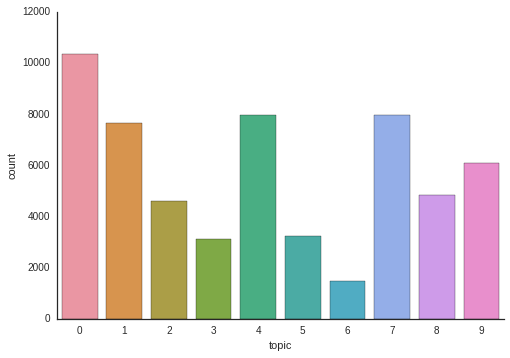

In [150]:
## distribution of providers among topics
ax = sns.countplot(x='topic',data=pd.DataFrame(topic_per_doc).rename(columns={0:'topic'}))
sns.despine()

### fraudulent providers

In [118]:
## excluded npis of provider_type internal medicine (excl date > 2015-01-01)
fraud_npi = pd.read_csv("internal_medicine_npi_fraud.csv", dtype={'npi':str})
fraud_npi.shape

(44, 1)

In [119]:
## color code for plotting
fraud_idx = by_npi.index.isin(list(fraud_npi['npi']))
len(fraud_idx)

In [187]:
fraud_label = pd.DataFrame(fraud_idx, columns=['fraud'])
fraud_label.loc[fraud_idx, 'fraud'] = '1'   # 1 for fraud
fraud_label.loc[~fraud_idx, 'fraud'] = '0'

In [145]:
## plot number of docs per topic
#topic_per_doc_df = (pd.Series(topic_per_doc).
#                     value_counts().
#                    to_frame().
#                    reset_index().
#                    rename(columns={'index':'topic',0:'number_of_providers'}))
topic_per_doc_df = (pd.concat([pd.DataFrame(topic_per_doc), fraud_label], axis=1, ignore_index=True).
                        rename(columns={0:'topic',1:'fraud'}))

In [146]:
topic_per_doc_df.head()

,topic,fraud
0,0,0
1,7,0
2,6,0
3,0,0
4,5,0


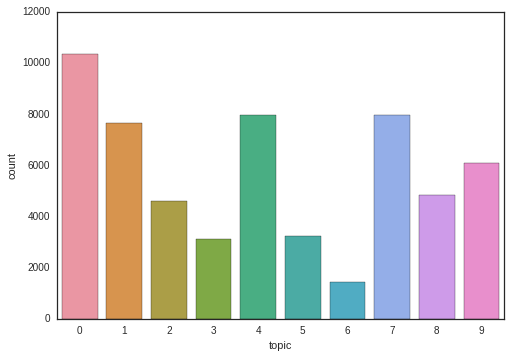

In [152]:
## distribution of non-fraudulent providers among topics
ax = sns.countplot(x='topic',data=topic_per_doc_df[topic_per_doc_df.fraud=='0'])

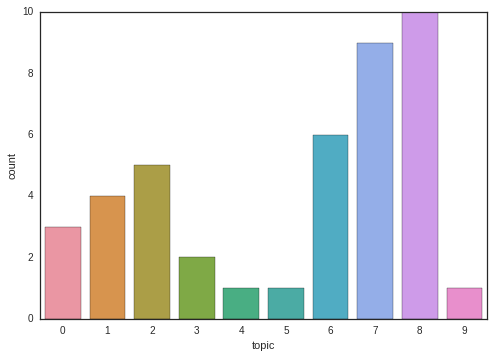

In [151]:
## distribution of fraudulent providers among topics
ax = sns.countplot(x='topic', data=topic_per_doc_df[topic_per_doc_df.fraud=='1'])

In [160]:
mydf = topic_per_doc_df.reset_index().groupby(['topic','fraud']).count().rename(columns={'index':'counts'}).reset_index()

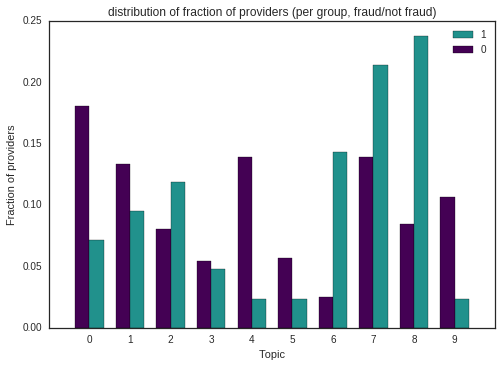

In [180]:
fig = plt.figure()
ax = fig.add_subplot(111)

space = 0.3

categories = range(10) #topics
conditions = ['0','1'] #fraud label

n = len(conditions)

width = (1 - space) / (len(conditions))
#print "width:", width

for i,cond in enumerate(conditions):
    #print "cond:", cond
    vals = mydf.loc[mydf.fraud == cond, 'counts'] / float(sum(mydf.loc[mydf.fraud == cond, 'counts']))
    #vals = topic_per_doc_df[topic_per_doc_df[:,0] == cond][:,2].astype(np.float)
    pos = [j - (1 - space) / 2. + i * width for j in range(0,len(categories))]
    ax.bar(pos, vals, width=width, label=cond, 
       color=cm.viridis(float(i) / n))
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])
    #ax.set_xticklabels(categories)
    ax.set_xticks(np.arange(0, 10, 1) )
    ax.set_xlim(-1, 10)
    ax.set_title('distribution of fraction of providers (per group, fraud/not fraud)')
    ax.set_ylabel("Fraction of providers")
    ax.set_xlabel("Topic")

Discrepancy in fractions between fraud/not fraud make topics 6 and 8 possibly useful for discriminating fraudulent providers.

About 24% (15%) of fraudent providers, i.e. 10 providers (6 providers) fall under topic 8 (6).

About 8% (2.5%) of non-fraudulent providers, i.e. 4583 providers (143 providers) fall under topic 8 (6).

## Improve on model
- reduce number of topics
- filter out patient visit columns or columns with very few observations?